# A/B Testing for Machine Learning Models 
* Notebook by Adam Lang
* Date: 12/5/2024



# Overview
* The goal of this page is to perform A/B testing of sequential addition of multiple machine learning models to an AI application and if there is or is not a difference in model rankings by adding more models.

# Inspiration for this work
* This work was inspired by this excellent blog post by Ivan Leo on how to A/B test your RAG outputs.
* Blog link: https://ivanleo.com/blog/are-your-eval-improvements-just-pure-chance

# Hypothesis
* Null hypothesis - Ho
    * Rankings won't change that much between 4 and 5 machine models compared to between 0 and 1, and 1 and 2 models. 

* Alternative hypothesis - H1
    * Rankings will change significantly by adding more machine models to the application. 




# Experimental Setup

* Output: Excel or CSV document

* Goal: Observe ranking metric changes between each of the additional machine learning models added to the AI application. 

* Setup:
    * First tab is metrics
    * Each tab after that will be sample rankings of ~100 award messages

* Specificity breakdown:
    * Tab 1 → 100%
    * Tab 2 → 50% specificity | 50% impact
    * Tab 3 → 33.33% specificity | 33.33% impact | 33.33% amplitude
    * Tab 4 → 25% specificity | 25% impact | 25% amplitude | 25% agency (“achievement”)
    * Tab 5 → 20% specificity | 20% impact | 20% amplitude | 20% agency | 20% communion (affiliation)

# Imports

In [55]:
#install scikit_posthocs
!pip install scikit-posthocs

In [56]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

from scipy import stats
from sklearn.metrics import ndcg_score
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from tqdm import tqdm


# Upload Dataset #1

In [57]:
## data upload
df = pd.read_pickle(<path to your data here>)
df.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,...,message_cleaned,message_length,lang,message_cleaned_full,length_bucket,client_id,amplitude_score,amplitude_label,spec_score,impact_score
0,27772765,25797340,176539268.0,173898569.0,NaN,149695768.0,0,620,Aluminum,Be Consumer Centric,...,Robert. Thank for always willing to help out w...,225,en,robert thank for always willing to help out wh...,"(208.0, 273.0]",2638.0,21.327212,2,0.9706,0.0834
1,27204636,21632252,176490655.0,173898489.0,8902091.0,149654935.0,0,620,Aluminum,Celebrate Success,...,Congrats on being the most engaged Site in our...,143,en,congrat on be the most engage site in our qfs ...,"(100.999, 155.0]",2638.0,0.000000,1,0.8031,0.0563
2,13533035,13201505,176218585.0,173898487.0,NaN,149426596.0,1,620,Silver,Focus & Get Things Done Fast,...,"Thank you, Cole, for working quickly and effic...",166,en,thank you cole for work quickly and efficientl...,"(155.0, 208.0]",2638.0,0.000000,1,0.9823,0.3927
3,26471804,13201505,176218475.0,173898486.0,NaN,149426485.0,1,620,Silver,Focus & Get Things Done Fast,...,"Thank you, Korey, for getting in the ceiling t...",174,en,thank you korey for get in the ceiling to get ...,"(155.0, 208.0]",2638.0,0.000000,1,0.9680,0.3785
4,27722515,24446712,176390601.0,173898519.0,8892529.0,149572115.0,0,620,Aluminum,Act as Owners,...,Thank you for going above and beyond in helpin...,214,en,thank you for go above and beyond in help char...,"(208.0, 273.0]",2638.0,0.000000,1,0.9681,0.1918


# EDA

In [58]:
## df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555210 entries, 0 to 555209
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rec_id                555210 non-null  int64  
 1   nom_id                555210 non-null  int64  
 2   award_id              555210 non-null  float64
 3   ah_id                 555210 non-null  float64
 4   link_id               138045 non-null  float64
 5   group_id              555210 non-null  float64
 6   award_private         555210 non-null  int64  
 7   product_id            555210 non-null  int64  
 8   award_type            555210 non-null  object 
 9   award_reason          555210 non-null  object 
 10  title                 555172 non-null  object 
 11  message               555210 non-null  object 
 12  award_date            555210 non-null  object 
 13  value                 555210 non-null  float64
 14  remaining_value       555210 non-null  float64
 15  

In [59]:
## columns
df.columns

Index(['rec_id', 'nom_id', 'award_id', 'ah_id', 'link_id', 'group_id',
       'award_private', 'product_id', 'award_type', 'award_reason', 'title',
       'message', 'award_date', 'value', 'remaining_value', 'product',
       'monetary_category', 'is_bulk', 'message_cleaned', 'message_length',
       'lang', 'message_cleaned_full', 'length_bucket', 'client_id',
       'amplitude_score', 'amplitude_label', 'spec_score', 'impact_score'],
      dtype='object')

In [60]:
## check nulls
df.isna().sum().sum()

417203

## Upload Dataset #2 -- this is the missing columns for agency and communion
* These are the feature scores/models missing from the dataset above:
1. agency ("achievement")
2. communion (affiliation)

In [61]:
## upload df2
df2 = pd.read_csv(<path to your data here>)
df2.head()

,Unnamed: 0,award_id,achievement/agency,affiliation/communion
0,0,176539268.0,1,1
1,1,176490655.0,2,1
2,2,176218585.0,2,0
3,3,176218475.0,1,0
4,4,176390601.0,3,3


# Merge 2 Datasets together

In [62]:
## award_id merge
df = pd.merge(df, df2[['award_id', 'achievement/agency', 'affiliation/communion']], 
              on='award_id', 
              how='left')

## head
df.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,...,lang,message_cleaned_full,length_bucket,client_id,amplitude_score,amplitude_label,spec_score,impact_score,achievement/agency,affiliation/communion
0,27772765,25797340,176539268.0,173898569.0,NaN,149695768.0,0,620,Aluminum,Be Consumer Centric,...,en,robert thank for always willing to help out wh...,"(208.0, 273.0]",2638.0,21.327212,2,0.9706,0.0834,1,1
1,27204636,21632252,176490655.0,173898489.0,8902091.0,149654935.0,0,620,Aluminum,Celebrate Success,...,en,congrat on be the most engage site in our qfs ...,"(100.999, 155.0]",2638.0,0.000000,1,0.8031,0.0563,2,1
2,13533035,13201505,176218585.0,173898487.0,NaN,149426596.0,1,620,Silver,Focus & Get Things Done Fast,...,en,thank you cole for work quickly and efficientl...,"(155.0, 208.0]",2638.0,0.000000,1,0.9823,0.3927,2,0
3,26471804,13201505,176218475.0,173898486.0,NaN,149426485.0,1,620,Silver,Focus & Get Things Done Fast,...,en,thank you korey for get in the ceiling to get ...,"(155.0, 208.0]",2638.0,0.000000,1,0.9680,0.3785,1,0
4,27722515,24446712,176390601.0,173898519.0,8892529.0,149572115.0,0,620,Aluminum,Act as Owners,...,en,thank you for go above and beyond in help char...,"(208.0, 273.0]",2638.0,0.000000,1,0.9681,0.1918,3,3


In [63]:
# df3 columns
df.columns

Index(['rec_id', 'nom_id', 'award_id', 'ah_id', 'link_id', 'group_id',
       'award_private', 'product_id', 'award_type', 'award_reason', 'title',
       'message', 'award_date', 'value', 'remaining_value', 'product',
       'monetary_category', 'is_bulk', 'message_cleaned', 'message_length',
       'lang', 'message_cleaned_full', 'length_bucket', 'client_id',
       'amplitude_score', 'amplitude_label', 'spec_score', 'impact_score',
       'achievement/agency', 'affiliation/communion'],
      dtype='object')

# Experimental Approach

1. **Sampling and Data Preparation**
    * Use random sampling to select about 100 award messages for each tab.
    * Calculate weighted scores for each tab based on the given percentages.

2. **Ranking Algorithm**
    * Use a simple weighted sum model for ranking, where each feature is multiplied by its weight and then summed.

3. **Ranking Comparison Metrics**
    * Kendall's Tau or Spearman's Rank Correlation Coefficient to compare rankings between tabs.
    * Mean Average Precision (MAP) or Normalized Discounted Cumulative Gain (NDCG) if you have ground truth relevance scores.

4. **Statistical Analysis**
    * Friedman test to check for significant differences across all tabs.
    * Post-hoc analysis (e.g., Nemenyi test) if Friedman test shows significant differences.


## Bootstrapping
* Adding bootstrapping to this analysis can provide more robust estimates of the ranking comparisons and help quantify the uncertainty in our results. 
* Bootstrapping is particularly useful here because it allows us to estimate the sampling distribution of our statistics (like Kendall's Tau) without making strong assumptions about the underlying distribution of the data.

* Here's how we will incorporate bootstrapping into our analysis:

1. We'll use bootstrapping to create multiple resamples for each tab.
2. For each resample, we'll calculate the rankings and comparison metrics.
3. We'll then compute confidence intervals for our comparison metrics.



* Key Reasons to add bootstrapping here:
    * Robust Estimates: Instead of a single Kendall's Tau value for each comparison, we now have a mean value and a 95% confidence interval. This gives us a better understanding of the uncertainty in our comparisons.
    * Distribution of Comparisons: The bootstrapping process allows us to see the distribution of Kendall's Tau values for each comparison, which can be particularly insightful for understanding the stability of the rankings across different subsets of the data.
    * Increased Confidence: With bootstrapped results, we can be more confident in our conclusions about whether adding more features significantly changes the rankings.
    * Handling of Variability: Bootstrapping helps account for the variability in our sample, which is especially useful given our relatively small sample size of 100 award messages.

* To interpret the results:

1. We will look at the mean Kendall's Tau values and their confidence intervals in the "Ranking Comparisons" sheet.
    * If the confidence interval includes 0, it suggests that the rankings between those tabs are not significantly different.
    * The width of the confidence interval gives you an idea of the uncertainty in the comparison.

2. Compare the bootstrapped results with the original Friedman test and post-hoc analysis.
    * If the bootstrapped results align with the Friedman test results, it strengthens your conclusions.
    * If there are discrepancies, it might indicate areas where more investigation is needed.

3. We need to pay special attention to the comparisons between adjacent tabs (e.g., Tab1 vs Tab2, Tab2 vs Tab3, etc.). These will directly address your hypothesis about the impact of adding more models to the ranking.


* This bootstrapped approach provides a more robust framework for testing the hypothesis about the changes in rankings as you we more models, giving greater confidence in our conclusions.




In [64]:
## rename these columns in the dataframe for our analysis

df = df.rename(columns={
    'spec_score': 'specificity',
    'amplitude_score': 'amplitude',
    'impact_score': 'impact'
})

In [65]:
#Check if all required columns are present inDataFrame:
required_columns = ['specificity', 'impact', 'amplitude', 'achievement/agency', 'affiliation/communion']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Warning: The following columns are missing from the DataFrame: {missing_columns}")

## Experiment #1 - Adding each model 1 by 1
* This was suggested by Management as the original order rankings.

In [27]:
# Create sample size and bootstrap iterations
sample_size = 100
n_bootstrap = 1000  # Number of bootstrap iterations

def create_weighted_scores(df_sample, weights):
    columns = list(weights.keys())
    missing_columns = [col for col in columns if col not in df_sample.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")
    weighted_scores = df_sample[columns] * pd.Series(weights)
    return weighted_scores.sum(axis=1)

def compare_rankings(ranking1, ranking2):
    tau, _ = stats.kendalltau(ranking1, ranking2)
    return tau

def bootstrap_compare_rankings(df_sample, weights1, weights2, n_iterations=1000):
    taus = []
    for _ in range(n_iterations):
        bootstrap_sample = df_sample.sample(n=len(df_sample), replace=True)
        scores1 = create_weighted_scores(bootstrap_sample, weights1)
        scores2 = create_weighted_scores(bootstrap_sample, weights2)
        rank1 = scores1.rank(ascending=False)
        rank2 = scores2.rank(ascending=False)
        tau = compare_rankings(rank1, rank2)
        taus.append(tau)
    return np.mean(taus), np.percentile(taus, [2.5, 97.5])

# Define the tabs with cumulative models and equal weights
tabs = {
    'Tab1': {'specificity': 1},
    'Tab2': {'specificity': 0.5, 'impact': 0.5},
    'Tab3': {'specificity': 1/3, 'impact': 1/3, 'amplitude': 1/3},
    'Tab4': {'specificity': 0.25, 'impact': 0.25, 'amplitude': 0.25, 'achievement/agency': 0.25},
    'Tab5': {'specificity': 0.2, 'impact': 0.2, 'amplitude': 0.2, 'achievement/agency': 0.2, 'affiliation/communion': 0.2}
}

# Sample 100 messages once, including all necessary columns
all_columns = list(set().union(*[set(weights.keys()) for weights in tabs.values()]))
all_columns.append('message')  # Add the message column if it exists and you want to include it
sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

results = {}
rankings = {}

for tab, weights in tabs.items():
    scores = create_weighted_scores(sampled_df, weights)
    rankings[tab] = scores.rank(ascending=False)
    results[tab] = sampled_df.assign(score=scores, rank=rankings[tab])

# Compare rankings with bootstrapping
comparisons = {}
tab_names = list(tabs.keys())
for i in range(len(tab_names) - 1):
    tab1, tab2 = tab_names[i], tab_names[i+1]
    comp_key = f"{tab1} vs {tab2}"
    mean_tau, ci = bootstrap_compare_rankings(sampled_df, tabs[tab1], tabs[tab2], n_bootstrap)
    comparisons[comp_key] = {'mean_tau': mean_tau, 'ci_lower': ci[0], 'ci_upper': ci[1]}

# Friedman test
friedman_data = pd.DataFrame(rankings)
chi2, p_value = friedmanchisquare(*[friedman_data[col] for col in friedman_data.columns])

# Post-hoc analysis
posthoc = sp.posthoc_nemenyi_friedman(friedman_data)

# Print results
print("Pairwise Comparisons:")
for comp, values in comparisons.items():
    print(f"{comp}:")
    print(f"  Mean Kendall's Tau: {values['mean_tau']:.4f}")
    print(f"  95% CI: ({values['ci_lower']:.4f}, {values['ci_upper']:.4f})")
    print()

print("Friedman Test:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

print("\nPost-hoc Analysis (Nemenyi test):")
print(posthoc)


Pairwise Comparisons:
Tab1 vs Tab2:
  Mean Kendall's Tau: 0.6084
  95% CI: (0.5210, 0.6876)

Tab2 vs Tab3:
  Mean Kendall's Tau: 0.2660
  95% CI: (0.1121, 0.4038)

Tab3 vs Tab4:
  Mean Kendall's Tau: 0.9632
  95% CI: (0.9449, 0.9768)

Tab4 vs Tab5:
  Mean Kendall's Tau: 0.9576
  95% CI: (0.9343, 0.9755)

Friedman Test:
Chi-square statistic: 6.3587
p-value: 0.1739

Post-hoc Analysis (Nemenyi test):
          Tab1      Tab2      Tab3      Tab4      Tab5
Tab1  1.000000  0.998445  0.549020  0.462324  0.316869
Tab2  0.998445  1.000000  0.733917  0.650824  0.490900
Tab3  0.549020  0.733917  1.000000  0.999927  0.995576
Tab4  0.462324  0.650824  0.999927  1.000000  0.999194
Tab5  0.316869  0.490900  0.995576  0.999194  1.000000


### Save Experiment #1 results to excel file

In [28]:
# Optional: Save results to Excel
with pd.ExcelWriter('ranking_analysis_results.xlsx') as writer:
    pd.DataFrame(comparisons).T.to_excel(writer, sheet_name='Pairwise Comparisons')
    pd.DataFrame({'Chi-square': chi2, 'p-value': p_value}, index=['Friedman Test']).to_excel(writer, sheet_name='Friedman Test')
    posthoc.to_excel(writer, sheet_name='Post-hoc Analysis')
    
    for tab, data in results.items():
        data.to_excel(writer, sheet_name=tab, index=False)

print("Results saved to 'ranking_analysis_results.xlsx'")

Results saved to 'ranking_analysis_results.xlsx'


## Experiment #2 - Reverse order of original tabs

In [68]:
# Create a reversed order of tabs
reversed_tabs = {
    'Tab1': {'affiliation/communion': 1},
    'Tab2': {'affiliation/communion': 0.5, 'achievement/agency': 0.5},
    'Tab3': {'affiliation/communion': 1/3, 'achievement/agency': 1/3, 'amplitude': 1/3},
    'Tab4': {'affiliation/communion': 0.25, 'achievement/agency': 0.25, 'amplitude': 0.25, 'impact': 0.25},
    'Tab5': {'affiliation/communion': 0.2, 'achievement/agency': 0.2, 'amplitude': 0.2, 'impact': 0.2, 'specificity': 0.2}
}

# Print the reversed tabs and their weights
print("Reversed Order Tabs and Weights:")
for tab, weights in reversed_tabs.items():
    print(f"{tab}: {weights}")
print()

# Run the experiment with the reversed order tabs
reversed_comparisons = {}
reversed_tab_names = list(reversed_tabs.keys())
for i in range(len(reversed_tab_names) - 1):
    tab1, tab2 = reversed_tab_names[i], reversed_tab_names[i+1]
    comp_key = f"{tab1} vs {tab2}"
    mean_tau, ci = bootstrap_compare_rankings(sampled_df, reversed_tabs[tab1], reversed_tabs[tab2], n_bootstrap)
    reversed_comparisons[comp_key] = {'mean_tau': mean_tau, 'ci_lower': ci[0], 'ci_upper': ci[1]}

print("Pairwise Comparisons (Reversed Order):")
for comp, values in reversed_comparisons.items():
    print(f"{comp}:")
    print(f"  Mean Kendall's Tau: {values['mean_tau']:.4f}")
    print(f"  95% CI: ({values['ci_lower']:.4f}, {values['ci_upper']:.4f})")
    print()

Reversed Order Tabs and Weights:
Tab1: {'affiliation/communion': 1}
Tab2: {'affiliation/communion': 0.5, 'achievement/agency': 0.5}
Tab3: {'affiliation/communion': 0.3333333333333333, 'achievement/agency': 0.3333333333333333, 'amplitude': 0.3333333333333333}
Tab4: {'affiliation/communion': 0.25, 'achievement/agency': 0.25, 'amplitude': 0.25, 'impact': 0.25}
Tab5: {'affiliation/communion': 0.2, 'achievement/agency': 0.2, 'amplitude': 0.2, 'impact': 0.2, 'specificity': 0.2}

Pairwise Comparisons (Reversed Order):
Tab1 vs Tab2:
  Mean Kendall's Tau: 0.5770
  95% CI: (0.4534, 0.6818)

Tab2 vs Tab3:
  Mean Kendall's Tau: 0.2362
  95% CI: (0.0948, 0.3777)

Tab3 vs Tab4:
  Mean Kendall's Tau: 0.9920
  95% CI: (0.9853, 0.9970)

Tab4 vs Tab5:
  Mean Kendall's Tau: 0.9959
  95% CI: (0.9902, 0.9996)



In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Assuming all the previous functions are defined (create_weighted_scores, compare_rankings, bootstrap_compare_rankings)

# Create a reversed order of tabs
reversed_tabs = {
    'Tab1': {'affiliation/communion': 1},
    'Tab2': {'affiliation/communion': 0.5, 'achievement/agency': 0.5},
    'Tab3': {'affiliation/communion': 1/3, 'achievement/agency': 1/3, 'amplitude': 1/3},
    'Tab4': {'affiliation/communion': 0.25, 'achievement/agency': 0.25, 'amplitude': 0.25, 'impact': 0.25},
    'Tab5': {'affiliation/communion': 0.2, 'achievement/agency': 0.2, 'amplitude': 0.2, 'impact': 0.2, 'specificity': 0.2}
}

# Print the reversed tabs and their weights
print("Reversed Order Tabs and Weights:")
for tab, weights in reversed_tabs.items():
    print(f"{tab}: {weights}")
print()

# Sample 100 messages once, including all necessary columns
all_columns = list(set().union(*[set(weights.keys()) for weights in reversed_tabs.values()]))
all_columns.append('message')  # Add the message column if it exists and you want to include it
sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

# Create results dictionary for plotting
results = {}
for tab, weights in reversed_tabs.items():
    scores = create_weighted_scores(sampled_df, weights)
    rank = scores.rank(ascending=False)
    results[tab] = sampled_df.assign(score=scores, rank=rank)

# Run the experiment with the reversed order tabs
reversed_comparisons = {}
reversed_tab_names = list(reversed_tabs.keys())
for i in range(len(reversed_tab_names) - 1):
    tab1, tab2 = reversed_tab_names[i], reversed_tab_names[i+1]
    comp_key = f"{tab1} vs {tab2}"
    mean_tau, ci = bootstrap_compare_rankings(sampled_df, reversed_tabs[tab1], reversed_tabs[tab2], n_bootstrap)
    reversed_comparisons[comp_key] = {'mean_tau': mean_tau, 'ci_lower': ci[0], 'ci_upper': ci[1]}

print("Pairwise Comparisons (Reversed Order):")
for comp, values in reversed_comparisons.items():
    print(f"{comp}:")
    print(f"  Mean Kendall's Tau: {values['mean_tau']:.4f}")
    print(f"  95% CI: ({values['ci_lower']:.4f}, {values['ci_upper']:.4f})")
    print()


Reversed Order Tabs and Weights:
Tab1: {'affiliation/communion': 1}
Tab2: {'affiliation/communion': 0.5, 'achievement/agency': 0.5}
Tab3: {'affiliation/communion': 0.3333333333333333, 'achievement/agency': 0.3333333333333333, 'amplitude': 0.3333333333333333}
Tab4: {'affiliation/communion': 0.25, 'achievement/agency': 0.25, 'amplitude': 0.25, 'impact': 0.25}
Tab5: {'affiliation/communion': 0.2, 'achievement/agency': 0.2, 'amplitude': 0.2, 'impact': 0.2, 'specificity': 0.2}

Pairwise Comparisons (Reversed Order):
Tab1 vs Tab2:
  Mean Kendall's Tau: 0.5785
  95% CI: (0.4640, 0.6882)

Tab2 vs Tab3:
  Mean Kendall's Tau: 0.2324
  95% CI: (0.0858, 0.3788)

Tab3 vs Tab4:
  Mean Kendall's Tau: 0.9920
  95% CI: (0.9852, 0.9969)

Tab4 vs Tab5:
  Mean Kendall's Tau: 0.9959
  95% CI: (0.9902, 0.9992)



In [75]:
# Function to plot rank changes across tabs
def plot_rank_changes(results):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    plt.figure(figsize=(12, 6))
    for i in range(len(rank_df)):
        plt.plot(rank_df.columns, rank_df.iloc[i], 'o-', alpha=0.1)
    plt.title("Change in Rank for Individual Items Across Tabs (Reversed Order)")
    plt.xlabel("Tab")
    plt.ylabel("Rank")
    plt.tight_layout()
    plt.savefig('rank_changes_reversed.png')
    plt.close()
    plt.show()

# Plot the changes in rank
plot_rank_changes(results)

### Save Experiment #2 results to excel file

In [69]:
# Optional: Save results to Excel
with pd.ExcelWriter('ranking_analysis_results.xlsx') as writer:
    pd.DataFrame(comparisons).T.to_excel(writer, sheet_name='Pairwise Comparisons')
    pd.DataFrame({'Chi-square': chi2, 'p-value': p_value}, index=['Friedman Test']).to_excel(writer, sheet_name='Friedman Test')
    posthoc.to_excel(writer, sheet_name='Post-hoc Analysis')
    
    for tab, data in results.items():
        data.to_excel(writer, sheet_name=tab, index=False)

print("Results saved to 'reverse_ranking_analysis_results.xlsx'")

Results saved to 'reverse_ranking_analysis_results.xlsx'


## Experiment #2b - 2 scenarios as per Product Team
* Defines two new scenarios based on their description:

1. Scenario1: {'specificity': 0.15, 'impact': 0.15, 'amplitude': 0.233, 'achievement/agency': 0.233, 'affiliation/communion': 0.234}
2. Scenario2: {'specificity': 0.1, 'impact': 0.1, 'amplitude': 0.1, 'achievement/agency': 0.35, 'affiliation/communion': 0.35}
3. Compares these two scenarios using the bootstrap_compare_rankings function.

4. Additionally compares each of these new scenarios with the original Tab5 configuration.

In [72]:
import numpy as np
import pandas as pd
from scipy import stats

# Assuming all the previous functions are defined (create_weighted_scores, compare_rankings, bootstrap_compare_rankings)

# Define the new scenarios
new_tabs = {
    'Scenario1': {'specificity': 0.15, 'impact': 0.15, 'amplitude': 0.233, 'achievement/agency': 0.233, 'affiliation/communion': 0.234},
    'Scenario2': {'specificity': 0.1, 'impact': 0.1, 'amplitude': 0.1, 'achievement/agency': 0.35, 'affiliation/communion': 0.35}
}

# Sample 100 messages once, including all necessary columns
all_columns = list(set().union(*[set(weights.keys()) for weights in new_tabs.values()]))
all_columns.append('message')  # Add the message column if it exists and you want to include it
sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

# Compare rankings with bootstrapping for the new scenarios
mean_tau, ci = bootstrap_compare_rankings(sampled_df, new_tabs['Scenario1'], new_tabs['Scenario2'], n_bootstrap)

print("Comparison of New Scenarios:")
print("Scenario1 vs Scenario2:")
print(f"  Mean Kendall's Tau: {mean_tau:.4f}")
print(f"  95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")
print()

# If you want to compare these new scenarios with the original Tab5
original_tab5 = {'specificity': 0.2, 'impact': 0.2, 'amplitude': 0.2, 'achievement/agency': 0.2, 'affiliation/communion': 0.2}

for scenario_name, scenario_weights in new_tabs.items():
    mean_tau, ci = bootstrap_compare_rankings(sampled_df, scenario_weights, original_tab5, n_bootstrap)
    print(f"{scenario_name} vs Original Tab5:")
    print(f"  Mean Kendall's Tau: {mean_tau:.4f}")
    print(f"  95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")
    print()

Comparison of New Scenarios:
Scenario1 vs Scenario2:
  Mean Kendall's Tau: 0.9043
  95% CI: (0.8748, 0.9312)

Scenario1 vs Original Tab5:
  Mean Kendall's Tau: 0.9980
  95% CI: (0.9947, 1.0000)

Scenario2 vs Original Tab5:
  Mean Kendall's Tau: 0.9042
  95% CI: (0.8725, 0.9336)



In [76]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Assuming all the previous functions are defined (create_weighted_scores, compare_rankings, bootstrap_compare_rankings)

# Define the new scenarios
new_tabs = {
    'Scenario1': {'specificity': 0.15, 'impact': 0.15, 'amplitude': 0.233, 'achievement/agency': 0.233, 'affiliation/communion': 0.234},
    'Scenario2': {'specificity': 0.1, 'impact': 0.1, 'amplitude': 0.1, 'achievement/agency': 0.35, 'affiliation/communion': 0.35}
}

# Add the original Tab5 to the scenarios for comparison
new_tabs['Original Tab5'] = {'specificity': 0.2, 'impact': 0.2, 'amplitude': 0.2, 'achievement/agency': 0.2, 'affiliation/communion': 0.2}

# Sample 100 messages once, including all necessary columns
all_columns = list(set().union(*[set(weights.keys()) for weights in new_tabs.values()]))
all_columns.append('message')  # Add the message column if it exists and you want to include it
sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

# Create results dictionary for plotting
results = {}
for scenario, weights in new_tabs.items():
    scores = create_weighted_scores(sampled_df, weights)
    rank = scores.rank(ascending=False)
    results[scenario] = sampled_df.assign(score=scores, rank=rank)

# Compare rankings with bootstrapping for the new scenarios
for i, scenario1 in enumerate(new_tabs.keys()):
    for scenario2 in list(new_tabs.keys())[i+1:]:
        mean_tau, ci = bootstrap_compare_rankings(sampled_df, new_tabs[scenario1], new_tabs[scenario2], n_bootstrap)
        print(f"{scenario1} vs {scenario2}:")
        print(f"  Mean Kendall's Tau: {mean_tau:.4f}")
        print(f"  95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")
        print()

# Function to plot rank changes across scenarios
def plot_rank_changes(results):
    rank_df = pd.DataFrame({scenario: data['rank'] for scenario, data in results.items()})
    plt.figure(figsize=(12, 6))
    for i in range(len(rank_df)):
        plt.plot(rank_df.columns, rank_df.iloc[i], 'o-', alpha=0.1)
    plt.title("Change in Rank for Individual Items Across Scenarios")
    plt.xlabel("Scenario")
    plt.ylabel("Rank")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('rank_changes_scenarios.png')
    plt.close()
    plt.show()

# Plot the changes in rank
plot_rank_changes(results)

Scenario1 vs Scenario2:
  Mean Kendall's Tau: 0.9041
  95% CI: (0.8742, 0.9314)

Scenario1 vs Original Tab5:
  Mean Kendall's Tau: 0.9980
  95% CI: (0.9943, 1.0000)

Scenario2 vs Original Tab5:
  Mean Kendall's Tau: 0.9034
  95% CI: (0.8706, 0.9300)



## Experiment #3 - Randomizing the order and weights

In [77]:
import random

def create_random_weights(features):
    weights = np.random.dirichlet(np.ones(len(features)))
    return dict(zip(features, weights))

def randomize_tabs(features, num_tabs):
    random_tabs = {}
    for i in range(1, num_tabs + 1):
        tab_features = random.sample(features, k=i)
        random_tabs[f'RandomTab{i}'] = create_random_weights(tab_features)
    return random_tabs

# List of all features
all_features = ['specificity', 'impact', 'amplitude', 'achievement/agency', 'affiliation/communion']

# Create randomized tabs
random_tabs = randomize_tabs(all_features, 5)

# Run the experiment with randomized tabs
random_comparisons = {}
random_tab_names = list(random_tabs.keys())
for i in range(len(random_tab_names) - 1):
    tab1, tab2 = random_tab_names[i], random_tab_names[i+1]
    comp_key = f"{tab1} vs {tab2}"
    mean_tau, ci = bootstrap_compare_rankings(sampled_df, random_tabs[tab1], random_tabs[tab2], n_bootstrap)
    random_comparisons[comp_key] = {'mean_tau': mean_tau, 'ci_lower': ci[0], 'ci_upper': ci[1]}

print("Randomized Tabs:")
for tab, weights in random_tabs.items():
    print(f"{tab}: {weights}")
print()

print("Pairwise Comparisons (Randomized Tabs):")
for comp, values in random_comparisons.items():
    print(f"{comp}:")
    print(f"  Mean Kendall's Tau: {values['mean_tau']:.4f}")
    print(f"  95% CI: ({values['ci_lower']:.4f}, {values['ci_upper']:.4f})")
    print()

Randomized Tabs:
RandomTab1: {'achievement/agency': 1.0}
RandomTab2: {'impact': 0.94748430102922, 'achievement/agency': 0.052515698970779956}
RandomTab3: {'affiliation/communion': 0.07378916792968623, 'amplitude': 0.34328693638473456, 'impact': 0.5829238956855791}
RandomTab4: {'affiliation/communion': 0.18687409860915719, 'amplitude': 0.1403235327489005, 'impact': 0.31754230578875914, 'achievement/agency': 0.35526006285318323}
RandomTab5: {'amplitude': 0.1218641828925506, 'affiliation/communion': 0.28878374857369316, 'specificity': 0.017754330969852468, 'impact': 0.01710673966354555, 'achievement/agency': 0.5544909979003583}

Pairwise Comparisons (Randomized Tabs):
RandomTab1 vs RandomTab2:
  Mean Kendall's Tau: 0.5670
  95% CI: (0.4407, 0.6747)

RandomTab2 vs RandomTab3:
  Mean Kendall's Tau: 0.2963
  95% CI: (0.1563, 0.4245)

RandomTab3 vs RandomTab4:
  Mean Kendall's Tau: 0.9129
  95% CI: (0.8886, 0.9343)

RandomTab4 vs RandomTab5:
  Mean Kendall's Tau: 0.9422
  95% CI: (0.9224, 0.9

### Save Experiment #3 to excel file

In [78]:
# Optional: Save results to Excel
with pd.ExcelWriter('ranking_analysis_results.xlsx') as writer:
    pd.DataFrame(comparisons).T.to_excel(writer, sheet_name='Pairwise Comparisons')
    pd.DataFrame({'Chi-square': chi2, 'p-value': p_value}, index=['Friedman Test']).to_excel(writer, sheet_name='Friedman Test')
    posthoc.to_excel(writer, sheet_name='Post-hoc Analysis')
    
    for tab, data in results.items():
        data.to_excel(writer, sheet_name=tab, index=False)

print("Results saved to 'reverse_ranking_analysis_results.xlsx'")

Results saved to 'reverse_ranking_analysis_results.xlsx'


## Experiment #4 - Listwise Comparison
* A listwise comparison would involve comparing all tabs simultaneously rather than in pairs. 
* We can modify the code to perform a listwise comparison using Kendall's W (also known as Kendall's coefficient of concordance). 
* This statistic measures the agreement among multiple rankings and ranges from 0 (no agreement) to 1 (complete agreement).

### Overview of this experiment
1. Implements the kendall_w function to calculate Kendall's W for multiple rankings.
2. Creates a bootstrap_kendall_w function to perform bootstrap sampling and calculate the mean and confidence interval for Kendall's W.
3. Performs the listwise comparison using Kendall's W and prints the results.
4. For comparison, it also calculates pairwise Kendall's tau values between all pairs of tabs.

### The output will show:

* The mean Kendall's W value and its 95% confidence interval, which represents the overall agreement among all tabs.
* Pairwise Kendall's tau values for all combinations of tabs, allowing you to see how individual pairs compare.

### Interpreting the results:

* Kendall's W ranges from 0 to 1, where 1 indicates perfect agreement among all rankings and 0 indicates no agreement.
* The pairwise Kendall's tau values range from -1 to 1, where 1 indicates perfect agreement, -1 perfect disagreement, and 0 no relationship.
* This approach gives you a comprehensive view of how all the tabs agree overall (Kendall's W) while still allowing you to see pairwise relationships (Kendall's tau).

In [71]:
from scipy.stats import kendalltau
import itertools

def create_weighted_scores(df_sample, weights):
    columns = list(weights.keys())
    missing_columns = [col for col in columns if col not in df_sample.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")
    weighted_scores = df_sample[columns] * pd.Series(weights)
    return weighted_scores.sum(axis=1)

def kendall_w(rankings):
    n = rankings.shape[0]  # number of items being ranked
    m = rankings.shape[1]  # number of judges (tabs in this case)
    
    # Calculate the sum of squared deviations
    mean_rank = np.mean(rankings, axis=1)
    S = np.sum((rankings - mean_rank.reshape(-1, 1))**2)
    
    # Calculate Kendall's W
    W = (12 * S) / (m**2 * (n**3 - n))
    
    return W

def bootstrap_kendall_w(df_sample, tabs, n_iterations=1000):
    w_values = []
    for _ in range(n_iterations):
        bootstrap_sample = df_sample.sample(n=len(df_sample), replace=True)
        rankings = pd.DataFrame()
        for tab, weights in tabs.items():
            scores = create_weighted_scores(bootstrap_sample, weights)
            rankings[tab] = scores.rank(ascending=False)
        w = kendall_w(rankings.values)
        w_values.append(w)
    return np.mean(w_values), np.percentile(w_values, [2.5, 97.5])

# Define the tabs with cumulative models and equal weights
tabs = {
    'Tab1': {'specificity': 1},
    'Tab2': {'specificity': 0.5, 'impact': 0.5},
    'Tab3': {'specificity': 1/3, 'impact': 1/3, 'amplitude': 1/3},
    'Tab4': {'specificity': 0.25, 'impact': 0.25, 'amplitude': 0.25, 'achievement/agency': 0.25},
    'Tab5': {'specificity': 0.2, 'impact': 0.2, 'amplitude': 0.2, 'achievement/agency': 0.2, 'affiliation/communion': 0.2}
}

# Sample 100 messages once, including all necessary columns
all_columns = list(set().union(*[set(weights.keys()) for weights in tabs.values()]))
all_columns.append('message')  # Add the message column if it exists and you want to include it
sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

# Perform listwise comparison
mean_w, ci = bootstrap_kendall_w(sampled_df, tabs, n_bootstrap)

print("Listwise Comparison Results:")
print(f"Mean Kendall's W: {mean_w:.4f}")
print(f"95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")

# Calculate pairwise Kendall's tau for comparison
print("\nPairwise Kendall's tau for comparison:")
tab_names = list(tabs.keys())
for tab1, tab2 in itertools.combinations(tab_names, 2):
    scores1 = create_weighted_scores(sampled_df, tabs[tab1])
    scores2 = create_weighted_scores(sampled_df, tabs[tab2])
    tau, _ = kendalltau(scores1, scores2)
    print(f"{tab1} vs {tab2}: {tau:.4f}")

Listwise Comparison Results:
Mean Kendall's W: 0.0734
95% CI: (0.0551, 0.0918)

Pairwise Kendall's tau for comparison:
Tab1 vs Tab2: 0.6075
Tab1 vs Tab3: 0.1411
Tab1 vs Tab4: 0.1479
Tab1 vs Tab5: 0.1415
Tab2 vs Tab3: 0.2683
Tab2 vs Tab4: 0.2743
Tab2 vs Tab5: 0.2614
Tab3 vs Tab4: 0.9632
Tab3 vs Tab5: 0.9438
Tab4 vs Tab5: 0.9572


# Experiment #5 - Rotating model orders

In [80]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from itertools import permutations

# Assuming all the previous functions are defined (create_weighted_scores, compare_rankings, bootstrap_compare_rankings)

# Define the models
models = ['specificity', 'impact', 'amplitude', 'achievement/agency', 'affiliation/communion']

# Function to create tabs based on a given order of models
def create_tabs(model_order):
    tabs = {}
    for i in range(1, 6):
        tab_models = model_order[:i]
        tabs[f'Tab{i}'] = {model: 1/i for model in tab_models}
    return tabs

# Function to plot rank changes across tabs
def plot_rank_changes(results, experiment_name):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    plt.figure(figsize=(12, 6))
    for i in range(len(rank_df)):
        plt.plot(rank_df.columns, rank_df.iloc[i], 'o-', alpha=0.1)
    plt.title(f"Change in Rank for Individual Items Across Tabs - {experiment_name}")
    plt.xlabel("Tab")
    plt.ylabel("Rank")
    plt.tight_layout()
    plt.savefig(f'rank_changes_{experiment_name}.png')
    plt.close()

# Generate all permutations of the models
all_permutations = list(permutations(models))

# Run experiments for each permutation
for perm_index, model_order in enumerate(all_permutations):
    print(f"\nExperiment {perm_index + 1} with order: {' -> '.join(model_order)}")
    
    tabs = create_tabs(model_order)
    
    # Sample 100 messages once, including all necessary columns
    all_columns = list(set().union(*[set(weights.keys()) for weights in tabs.values()]))
    all_columns.append('message')  # Add the message column if it exists and you want to include it
    sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

    results = {}
    rankings = {}

    for tab, weights in tabs.items():
        scores = create_weighted_scores(sampled_df, weights)
        rankings[tab] = scores.rank(ascending=False)
        results[tab] = sampled_df.assign(score=scores, rank=rankings[tab])

    # Compare rankings with bootstrapping
    comparisons = {}
    tab_names = list(tabs.keys())
    for i in range(len(tab_names) - 1):
        tab1, tab2 = tab_names[i], tab_names[i+1]
        comp_key = f"{tab1} vs {tab2}"
        mean_tau, ci = bootstrap_compare_rankings(sampled_df, tabs[tab1], tabs[tab2], n_bootstrap)
        comparisons[comp_key] = {'mean_tau': mean_tau, 'ci_lower': ci[0], 'ci_upper': ci[1]}

    # Friedman test
    friedman_data = pd.DataFrame(rankings)
    chi2, p_value = friedmanchisquare(*[friedman_data[col] for col in friedman_data.columns])

    # Post-hoc analysis
    posthoc = sp.posthoc_nemenyi_friedman(friedman_data)

    # Print results
    print("Pairwise Comparisons:")
    for comp, values in comparisons.items():
        print(f"{comp}:")
        print(f"  Mean Kendall's Tau: {values['mean_tau']:.4f}")
        print(f"  95% CI: ({values['ci_lower']:.4f}, {values['ci_upper']:.4f})")
    print()

    print("Friedman Test:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")

    print("\nPost-hoc Analysis (Nemenyi test):")
    print(posthoc)

    # Plot rank changes
    plot_rank_changes(results, f"perm_{perm_index + 1}")


Experiment 1 with order: specificity -> impact -> amplitude -> achievement/agency -> affiliation/communion
Pairwise Comparisons:
Tab1 vs Tab2:
  Mean Kendall's Tau: 0.6070
  95% CI: (0.5206, 0.6839)
Tab2 vs Tab3:
  Mean Kendall's Tau: 0.2678
  95% CI: (0.1162, 0.4084)
Tab3 vs Tab4:
  Mean Kendall's Tau: 0.9634
  95% CI: (0.9461, 0.9771)
Tab4 vs Tab5:
  Mean Kendall's Tau: 0.9573
  95% CI: (0.9345, 0.9735)

Friedman Test:
Chi-square statistic: 6.3587
p-value: 0.1739

Post-hoc Analysis (Nemenyi test):
          Tab1      Tab2      Tab3      Tab4      Tab5
Tab1  1.000000  0.998445  0.549020  0.462324  0.316869
Tab2  0.998445  1.000000  0.733917  0.650824  0.490900
Tab3  0.549020  0.733917  1.000000  0.999927  0.995576
Tab4  0.462324  0.650824  0.999927  1.000000  0.999194
Tab5  0.316869  0.490900  0.995576  0.999194  1.000000

Experiment 2 with order: specificity -> impact -> amplitude -> affiliation/communion -> achievement/agency
Pairwise Comparisons:
Tab1 vs Tab2:
  Mean Kendall's Tau

# Experiment 5 -- with focused results

In [81]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from itertools import permutations

# Assuming all the previous functions are defined (create_weighted_scores, compare_rankings, bootstrap_compare_rankings)

# Define the models
models = ['specificity', 'impact', 'amplitude', 'achievement/agency', 'affiliation/communion']

def create_tabs(model_order):
    tabs = {}
    for i in range(1, 6):
        tab_models = model_order[:i]
        tabs[f'Tab{i}'] = {model: 1/i for model in tab_models}
    return tabs

def plot_rank_changes(results, experiment_name):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    plt.figure(figsize=(12, 6))
    for i in range(len(rank_df)):
        plt.plot(rank_df.columns, rank_df.iloc[i], 'o-', alpha=0.1)
    plt.title(f"Change in Rank for Individual Items Across Tabs - {experiment_name}")
    plt.xlabel("Tab")
    plt.ylabel("Rank")
    plt.tight_layout()
    plt.savefig(f'rank_changes_{experiment_name}.png')
    plt.close()

all_permutations = list(permutations(models))

significant_permutations = []
significant_changes_after_3 = []

for perm_index, model_order in enumerate(all_permutations):
    print(f"\nExperiment {perm_index + 1} with order: {' -> '.join(model_order)}")
    
    tabs = create_tabs(model_order)
    
    all_columns = list(set().union(*[set(weights.keys()) for weights in tabs.values()]))
    all_columns.append('message')
    sampled_df = df[all_columns].sample(n=sample_size, random_state=42)

    results = {}
    rankings = {}

    for tab, weights in tabs.items():
        scores = create_weighted_scores(sampled_df, weights)
        rankings[tab] = scores.rank(ascending=False)
        results[tab] = sampled_df.assign(score=scores, rank=rankings[tab])

    comparisons = {}
    tab_names = list(tabs.keys())
    for i in range(len(tab_names) - 1):
        tab1, tab2 = tab_names[i], tab_names[i+1]
        comp_key = f"{tab1} vs {tab2}"
        mean_tau, ci = bootstrap_compare_rankings(sampled_df, tabs[tab1], tabs[tab2], n_bootstrap)
        comparisons[comp_key] = {'mean_tau': mean_tau, 'ci_lower': ci[0], 'ci_upper': ci[1]}

    friedman_data = pd.DataFrame(rankings)
    chi2, p_value = friedmanchisquare(*[friedman_data[col] for col in friedman_data.columns])

    if p_value < 0.05:
        significant_permutations.append((perm_index + 1, model_order, p_value))

    # Check for significant changes after 3 models
    for i in range(3, 5):
        tab1, tab2 = f'Tab{i}', f'Tab{i+1}'
        mean_tau = comparisons[f"{tab1} vs {tab2}"]['mean_tau']
        ci_lower = comparisons[f"{tab1} vs {tab2}"]['ci_lower']
        ci_upper = comparisons[f"{tab1} vs {tab2}"]['ci_upper']
        
        if ci_lower > 0 or ci_upper < 0:  # Check if CI doesn't include 0
            significant_changes_after_3.append((perm_index + 1, model_order, i, mean_tau, ci_lower, ci_upper))

    plot_rank_changes(results, f"perm_{perm_index + 1}")

print("\nPermutations with significant Friedman test results (p < 0.05):")
for perm_index, model_order, p_value in significant_permutations:
    print(f"Permutation {perm_index}: {' -> '.join(model_order)}, p-value: {p_value:.4f}")

print("\nPermutations with significant changes after 3 models:")
for perm_index, model_order, tab_num, mean_tau, ci_lower, ci_upper in significant_changes_after_3:
    print(f"Permutation {perm_index}: {' -> '.join(model_order)}")
    print(f"  Significant change between Tab{tab_num} and Tab{tab_num+1}")
    print(f"  Mean Kendall's Tau: {mean_tau:.4f}")
    print(f"  95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")
    print()


Experiment 1 with order: specificity -> impact -> amplitude -> achievement/agency -> affiliation/communion

Experiment 2 with order: specificity -> impact -> amplitude -> affiliation/communion -> achievement/agency

Experiment 3 with order: specificity -> impact -> achievement/agency -> amplitude -> affiliation/communion

Experiment 4 with order: specificity -> impact -> achievement/agency -> affiliation/communion -> amplitude

Experiment 5 with order: specificity -> impact -> affiliation/communion -> amplitude -> achievement/agency

Experiment 6 with order: specificity -> impact -> affiliation/communion -> achievement/agency -> amplitude

Experiment 7 with order: specificity -> amplitude -> impact -> achievement/agency -> affiliation/communion

Experiment 8 with order: specificity -> amplitude -> impact -> affiliation/communion -> achievement/agency

Experiment 9 with order: specificity -> amplitude -> achievement/agency -> impact -> affiliation/communion

Experiment 10 with order: s

# Data Visualizations
* Here are some useful visualizations of the results:

1. Heatmap of Kendall's Tau values
    * We can easily see the similarity between all pairs of tabs at a glance.
2. Confidence Interval Plot for Kendall's Tau comparisons
    * Visualize the uncertainty in your Kendall's Tau estimates and quickly identify which comparisons are significantly different from zero.
3. Distribution of Bootstrapped Kendall's Tau values
    * Understand the variability and distribution of Kendall's Tau for specific comparisons.
4. Rank Correlation Matrix
    * See how closely related the rankings are across all tabs, using Spearman's rank correlation.
5. Box plots of scores across tabs
    * Score Boxplots: This will help us compare the distribution of scores across different tabs to see how adding features affects the overall score distribution.




These visualizations should provide a comprehensive view of how rankings change as we add more models, helping ffectively communicate the findings and support conclusions regarding the hypothesis.

## 1. Heatmap of Kendall's Tau values

In [34]:
def create_heatmap(comparisons):
    # Extract unique tab names
    tabs = sorted(set([comp.split(' vs ')[0] for comp in comparisons.keys()] + 
                      [comp.split(' vs ')[1] for comp in comparisons.keys()]))
    
    # Create the tau matrix
    n = len(tabs)
    tau_matrix = np.eye(n)  # Initialize with 1s on the diagonal
    
    for i in range(n):
        for j in range(i+1, n):
            key = f"{tabs[i]} vs {tabs[j]}"
            if key in comparisons:
                tau_value = comparisons[key]['mean_tau']
            else:
                key = f"{tabs[j]} vs {tabs[i]}"
                tau_value = comparisons[key]['mean_tau'] if key in comparisons else np.nan
            
            tau_matrix[i, j] = tau_matrix[j, i] = tau_value
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(tau_matrix, dtype=bool), k=1)  # Mask for upper triangle
    sns.heatmap(tau_matrix, annot=True, cmap='coolwarm', xticklabels=tabs, yticklabels=tabs, 
                mask=mask, vmin=-1, vmax=1, center=0)
    plt.title("Heatmap of Kendall's Tau Values")
    plt.tight_layout()
    #plt.savefig('kendall_tau_heatmap.png')
    #plt.close()
    plt.show();



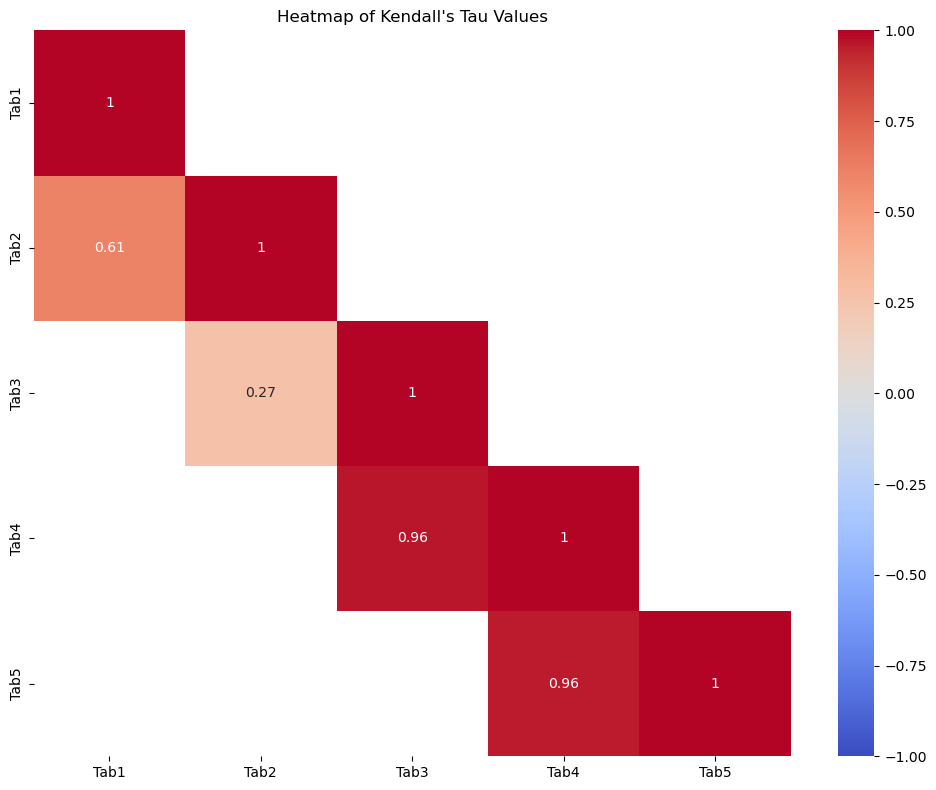

In [35]:
## plot heatmap
create_heatmap(comparisons)

## 2. Confidence Interval Plot for Kendall's Tau Comparisons

In [38]:
# 2. Confidence Interval Plot
def create_ci_plot(comparisons):
    plt.figure(figsize=(12, 6))
    for i, (comp, values) in enumerate(comparisons.items()):
        plt.plot([i, i], [values['ci_lower'], values['ci_upper']], 'b-')
        plt.plot(i, values['mean_tau'], 'ro')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xticks(range(len(comparisons)), comparisons.keys(), rotation=45, ha='right')
    plt.ylabel("Kendall's Tau")
    plt.title("Confidence Intervals for Kendall's Tau Comparisons")
    plt.tight_layout()
    #plt.savefig('kendall_tau_ci_plot.png')
    #plt.close()
    plt.show();


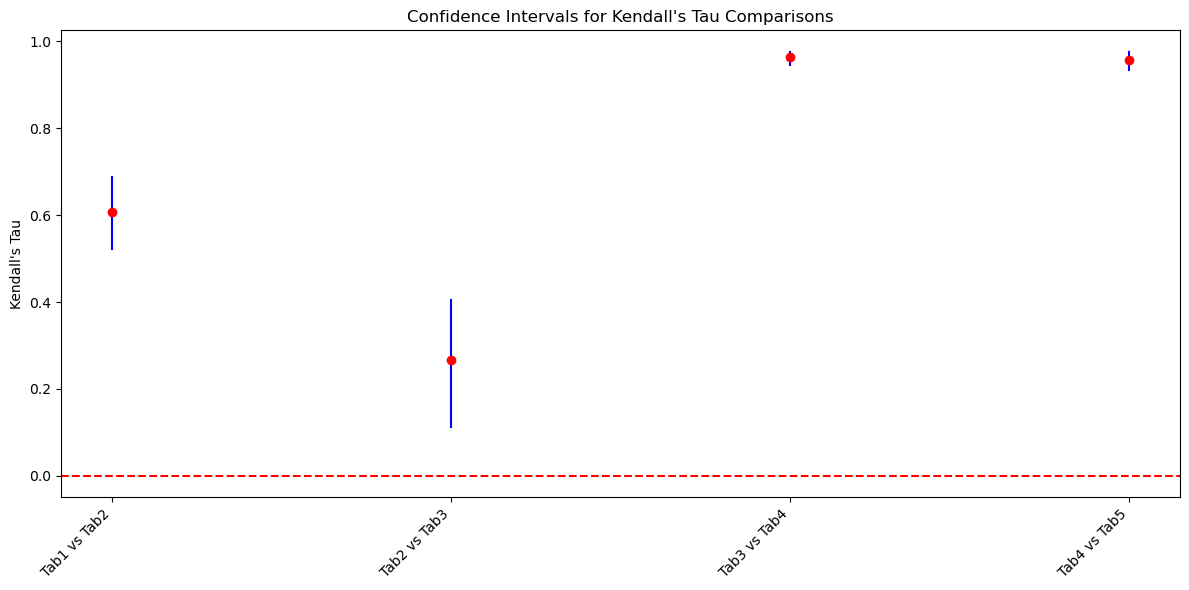

In [39]:
## plot confidence interval
create_ci_plot(comparisons)

## 3. Distribution of Bootstrapped Kendall's Tau Values

In [43]:
# 3. Distribution of Bootstrapped Kendall's Tau values
def plot_bootstrap_distribution(df, weights1, weights2, n_bootstrap=1000, label=''):
    taus = []
    for _ in range(n_bootstrap):
        bootstrap_sample = df.sample(n=len(df), replace=True)
        scores1 = create_weighted_scores(bootstrap_sample, weights1)
        scores2 = create_weighted_scores(bootstrap_sample, weights2)
        rank1 = scores1.rank(ascending=False)
        rank2 = scores2.rank(ascending=False)
        tau = compare_rankings(rank1, rank2)
        taus.append(tau)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(taus, kde=True)
    plt.title(f"Distribution of Bootstrapped Kendall's Tau: {label}")
    plt.xlabel("Kendall's Tau")
    plt.savefig(f'bootstrap_distribution_{label.replace(" ", "_")}.png')
    plt.close()
    plt.show();

### Bootstrap distribution plots for all tab comparisons
* To make our point about the impact of adding more models, we will create the bootstrap distribution plot for all tab comparisons. 

* This will create a separate plot for each pair of tabs, allowing us to see how the distribution of Kendall's Tau changes as you we more models to the ranking system.

In [45]:
# Create bootstrap distribution plots for all tab comparisons
for i, (tab1, weights1) in enumerate(tabs.items()):
    for tab2, weights2 in list(tabs.items())[i+1:]:
        label = f"{tab1} vs {tab2}"
        plot_bootstrap_distribution(df, weights1, weights2, n_bootstrap=1000, label=label)

## 4. Rank Correlation Matrix

In [46]:
# 4. Rank Correlation Matrix
def create_rank_correlation_matrix(results):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    corr_matrix = rank_df.corr(method='spearman')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Rank Correlation Matrix")
    plt.tight_layout()
    plt.savefig('rank_correlation_matrix.png')
    plt.close()
    plt.show();

In [47]:
## plot rank correlation matrix
create_rank_correlation_matrix(results)

## 5. Box Plot of Scores Across Tabs

In [48]:
# 5. Box plots of scores across tabs
def create_score_boxplots(results):
    score_df = pd.DataFrame({tab: data['score'] for tab, data in results.items()})
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=score_df)
    plt.title("Distribution of Scores Across Tabs")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('score_boxplots.png')
    plt.close()
    plt.show();


In [49]:
## plot boxplots
create_score_boxplots(results)

## Additional Plots and Comparisons

### 1. Cumulative Distribution Function (CDF) of scores for each tab

In [50]:
## function to plot cdfs
def plot_score_cdfs(results):
    plt.figure(figsize=(12, 6))
    for tab, data in results.items():
        sns.ecdfplot(data=data['score'], label=tab)
    plt.title("Cumulative Distribution of Scores Across Tabs")
    plt.xlabel("Score")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.tight_layout()
    plt.savefig('score_cdfs.png')
    plt.close()
    plt.show();


## plot cdfs
plot_score_cdfs(results)

### 2. Pairwise scatter plots of ranks

In [52]:
# function to create rank scatter plots
def plot_rank_scatters(results):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    sns.pairplot(rank_df, height=2, aspect=1.5)
    plt.suptitle("Pairwise Scatter Plots of Ranks", y=1.02)
    plt.tight_layout()
    plt.savefig('rank_scatters.png')
    plt.close()
    plt.show();

## plot rank scatter plots
plot_rank_scatters(results)

### 3. Change in Rank for Individual Items Across Tabs

In [53]:
## function to plot rank changes across tabs
def plot_rank_changes(results):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    plt.figure(figsize=(12, 6))
    for i in range(len(rank_df)):
        plt.plot(rank_df.columns, rank_df.iloc[i], 'o-', alpha=0.1)
    plt.title("Change in Rank for Individual Items Across Tabs")
    plt.xlabel("Tab")
    plt.ylabel("Rank")
    plt.tight_layout()
    plt.savefig('rank_changes.png')
    plt.close()
    plt.show();

## plot the changes in rank 
plot_rank_changes(results)

### 4. Distribution of rank changes between adjacent tabs

In [54]:
## function to plot rank change distribution between tabs
def plot_rank_change_distribution(results):
    rank_df = pd.DataFrame({tab: data['rank'] for tab, data in results.items()})
    tabs = list(rank_df.columns)
    plt.figure(figsize=(12, 6))
    for i in range(len(tabs) - 1):
        changes = rank_df[tabs[i+1]] - rank_df[tabs[i]]
        sns.histplot(changes, kde=True, label=f'{tabs[i]} to {tabs[i+1]}')
    plt.title("Distribution of Rank Changes Between Adjacent Tabs")
    plt.xlabel("Change in Rank")
    plt.legend()
    plt.tight_layout()
    plt.savefig('rank_change_distribution.png')
    plt.close()
    plt.show();


## plot results
plot_rank_change_distribution(results)

# Summary of Visualizations
By creating all these plots, we now have a comprehensive visual analysis that covers:

1. Overall similarities between tab rankings (heatmap and rank correlation matrix)
2. Uncertainties in comparisons (confidence interval plot)
3. Distributions of similarities for each pair of tabs (bootstrap distribution plots)
4. Changes in individual item rankings across tabs (rank changes plot)
5. Distributions of scores and ranks for each tab (boxplots, CDFs, and scatter plots)

This diverse set of visualizations will provide strong support for our analysis and help us effectively communicate findings regarding the impact of adding more models to the ranking system.


